In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import time
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt

#Turn all the randomisation off to ensure the results of every execution is the same 
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Define Image Dataset structure and image transform

In [19]:
IMG_SIZE = 224
FOLDER_PATH = "Images/100"

class ImageDataSet(Dataset):
    def __init__(self, image_names, transform):
        self.file_names = []
        self.labels = []
        for numeric_label, names in enumerate(image_names):
            self.labels.extend([numeric_label]*len(names))
            self.file_names.extend(names)

        self.transform = transform

    def __getitem__(self, index):
        img_name = self.file_names[index]
        img = Image.open(img_name).convert('RGB')
        img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.file_names)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Offically used by Pytorch
])


# labels = [folder for folder in os.listdir(FOLDER_PATH)]
labels = ["B_Cells", "CD4+_T_Cells", "CD8+_T_Cells"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))

    
dataset = ImageDataSet(image_names, transform)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(image_names))
model = model.to(device)

In [22]:
num_epochs = 100
patience = 10 #for early stopping
batch_size = 32
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
_, subset = train_test_split(list(range(len(dataset))), test_size=0.5, random_state=0)

train_idx, temp_idx = train_test_split(subset, test_size=0.3, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [24]:
best_val_loss = float('inf')
epoch_no_improvement = 0
best_model_parameters = None


cnn_training_start = time.time()
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss/len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_parameters = model.state_dict()
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1
        if epoch_no_improvement == patience:
            print(f"No improvement for {patience} epoches. Early stopping.")
            break
cnn_training_end = time.time()

if best_model_parameters is not None:
    model.load_state_dict(best_model_parameters)

Epoch [1/100], Loss: 1.0886
Validation Loss: 1.1123, Accuracy: 44.18%
Epoch [2/100], Loss: 1.0476
Validation Loss: 1.5130, Accuracy: 42.54%
Epoch [3/100], Loss: 1.0436
Validation Loss: 1.3233, Accuracy: 38.35%
Epoch [4/100], Loss: 1.0325
Validation Loss: 1.2993, Accuracy: 33.25%
Epoch [5/100], Loss: 1.0198
Validation Loss: 1.1893, Accuracy: 44.24%
Epoch [6/100], Loss: 1.0097
Validation Loss: 1.1301, Accuracy: 42.28%
Epoch [7/100], Loss: 0.9909
Validation Loss: 2.4491, Accuracy: 37.17%
Epoch [8/100], Loss: 0.9700
Validation Loss: 1.1065, Accuracy: 43.46%
Epoch [9/100], Loss: 0.9552
Validation Loss: 1.1140, Accuracy: 44.37%
Epoch [10/100], Loss: 0.9110
Validation Loss: 1.3026, Accuracy: 40.18%
Epoch [11/100], Loss: 0.8491
Validation Loss: 1.4040, Accuracy: 35.99%
Epoch [12/100], Loss: 0.7483
Validation Loss: 1.4800, Accuracy: 35.34%
Epoch [13/100], Loss: 0.6478
Validation Loss: 1.3195, Accuracy: 37.04%
Epoch [14/100], Loss: 0.5591
Validation Loss: 1.7989, Accuracy: 37.70%
Epoch [15/100],

In [25]:
torch.save(model.state_dict(), 'CNN_model.pth')

In [26]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# print(classification_report(y_true, y_pred, target_names=["Tumor", "Immune"]))
pretrained_cnn_accuracy = accuracy_score(y_true, y_pred)
print(pretrained_cnn_accuracy)

0.42053629823413996


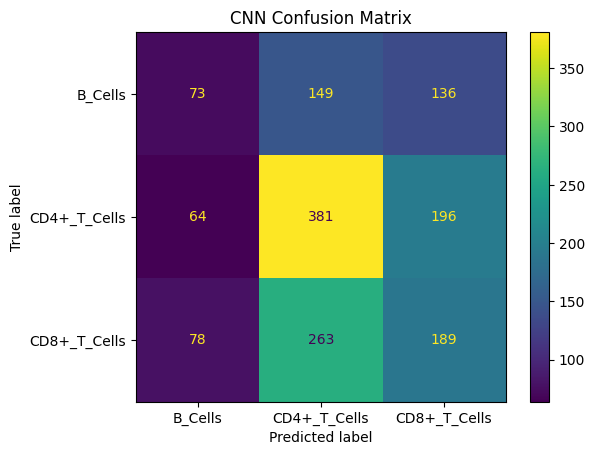

In [28]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)

cm_display.plot()
plt.title("CNN Confusion Matrix")
plt.show()